<a href="https://colab.research.google.com/github/lanarich/DL/blob/main/homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




In [1]:
%%bash
pip install transformers datasets evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [3]:
# Загрузим данные с попощью библиотеки библиотеки datasets

from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:5%]')


gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


gazeta_train.jsonl:   0%|          | 0.00/550M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/56.1M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/61.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60964 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6793 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6369 [00:00<?, ? examples/s]

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [4]:
dataset

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url'],
    num_rows: 3048
})

In [5]:
print(f"Текст: {dataset['text'][0]}\n\nСаммари:{dataset['summary'][0]}")

Текст: Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек. Также ставку налога могут корректировать региональные власти: согласно Налоговому кодексу, базовый тариф, установленный правительством, может быть уменьшен в пять раз или увеличен до 10 раз. Сборы идут в региональные бюджеты, откуда растекаются на общие нужды. Транспортный налог — один из основных источников бюджетных доходов — предлагается направить исключительно на дорожные фонды. Так, автомобилисты будут понимать, за что они платят, а дорожники будут иметь гарантированный доход. Кроме налога дорожные фонды будут пополняться за счет бюджетных средств и проезда по платным дорогам. Более того, транспортный налог предлагается завуалировать в акцизы на бензин. Привычную и раздражающую систему ежегодной оплаты квитанции предлагается изменить, включив налог в стоимость топлива. Минэкономразвития говорит об удвоении акцизы, которая сегодня составляе

In [6]:
# Подготовим данные для модели Bert

model_name = 'deepvk/bert-base-uncased' # Указание модели BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(examples, use_padding=True):

    inputs = tokenizer(examples['text'], max_length=512, truncation=True, padding='max_length' if use_padding else False)
    labels = tokenizer(examples['summary'], max_length=128, truncation=True, padding='max_length' if use_padding else False)

    inputs['labels'] = labels['input_ids']
    return inputs

tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/449k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
tokenized_dataset = dataset.map(preprocess, batched=False)
tokenized_dataset.set_format('torch')

Map:   0%|          | 0/3048 [00:00<?, ? examples/s]

In [8]:
tokenized_dataset

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 3048
})

Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [9]:
from torch.utils.data import DataLoader

split_dataset = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True)

train_dataloader = DataLoader(split_dataset['train'], batch_size=75, shuffle=True)
eval_dataloader = DataLoader(split_dataset['test'], batch_size=75)

In [10]:
print("Тренировочный датасет:")
print(split_dataset['train'])

print("Валидационный датасет:")
print(split_dataset['test'])

Тренировочный датасет:
Dataset({
    features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 2438
})
Валидационный датасет:
Dataset({
    features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 610
})


## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [11]:
class BertSummarizer(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=768, num_decoder_layers=3, num_heads=8, dropout=0.1):
        super(BertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size

        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)

        # Декодер на основе Transformer
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=num_decoder_layers
        )

        # Выходной слой
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    # Функция для создания маски для предотвращения заглядывания вперед в декодере
    def generate_square_subsequent_mask(self, T):
        mask = (torch.triu(torch.ones(T, T)) == 1).transpose(0, 1)
        return mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state  # Выходы BERT для использования в декодере

        # Эмбеддинги для входных токенов декодера
        embedded = self.embedding(decoder_input_ids)

        # Генерация маски для предотвращения заглядывания вперед
        decoder_attention_mask = self.generate_square_subsequent_mask(decoder_input_ids.size(1)).to(input_ids.device)

        # Проход через декодер
        decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)

        # Выход через выходной слой
        output = self.fc_out(decoder_output)

        return self.softmax(output)

    def generate(self, input_ids, attention_mask, tokenizer, max_len=50):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        batch_size = input_ids.size(0)

        # Начинаем с токена [CLS] или [BOS] (начало последовательности)
        decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)

        generated_tokens = []

        for _ in range(max_len):
            embedded = self.embedding(decoder_input_ids)  # [batch_size, seq_len, hidden_size]
            decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device)
            decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
            output = self.fc_out(decoder_output)  # [batch_size, seq_len, vocab_size]

            # Получаем токен с наибольшей вероятностью
            next_token_logits = output[:, -1, :]  # Последний токен из последовательности
            next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

            # Добавляем предсказанный токен к последовательности декодера
            decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)

            # Останавливаем генерацию, если достигли токена [EOS]
            if next_token_id.item() == tokenizer.eos_token_id:
                break
        generated_sequence = tokenizer.decode(decoder_input_ids.squeeze().tolist(), skip_special_tokens=True)

        return generated_sequence

In [12]:
# Инициализируем нашу модель и посморим на ее архитектруру

model = BertSummarizer(bert_model_name=model_name)
model = model.to('cuda')
model

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

BertSummarizer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [13]:
# Посмотрим на генерацию без обучения

eval_data_sample = next(iter(eval_dataloader))
model.generate(eval_data_sample['input_ids'][:1].to('cuda'), eval_data_sample['attention_mask'][:1].to('cuda'), tokenizer)

'##тации пенсию graph аттра ##itel ##opo ##ков пресс сахарнои лечить ##тал решет ##банк ##ательных федерального пятыи ммм je адекват нестерпи исчезли понрав япония аде независимость комнатах ##uz заря ##сою упоминается выходи газетах колесах полная инфекции подъезд ##ненным роджер января ремонт пон несов фабрики сантехника фас живете немало ##бут лепест высоте'

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


In [14]:
import torch.optim as optim
import matplotlib.pyplot as plt


def train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    outputs = model(input_ids, attention_mask, decoder_input_ids[:, :-1])
    loss = criterion(outputs.reshape(-1, outputs.size(-1)), decoder_input_ids[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()

    return loss.item()


def eval_step(model, input_ids, attention_mask, decoder_input_ids, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, decoder_input_ids[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), decoder_input_ids[:, 1:].reshape(-1))

    return loss.item()

def train_model(model, train_dataloader, eval_dataloader, optimizer, criterion, num_epochs=3):
    train_losses = []
    eval_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            decoder_input_ids = batch['labels'].to('cuda')

            train_loss = train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion)
            total_train_loss += train_loss

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}')

        model.eval()
        total_eval_loss = 0

        for batch in eval_dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            decoder_input_ids = batch['labels'].to('cuda')

            eval_loss = eval_step(model, input_ids, attention_mask, decoder_input_ids, criterion)
            total_eval_loss += eval_loss

        avg_eval_loss = total_eval_loss / len(eval_dataloader)
        eval_losses.append(avg_eval_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Eval Loss: {avg_eval_loss:.4f}')


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(eval_losses, label='Eval Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Eval Loss per Epoch')
    plt.show()

Epoch 1/10, Train Loss: 4.3703
Epoch 1/10, Eval Loss: 3.8134
Epoch 2/10, Train Loss: 3.7091
Epoch 2/10, Eval Loss: 3.6870
Epoch 3/10, Train Loss: 3.4719
Epoch 3/10, Eval Loss: 3.5270
Epoch 4/10, Train Loss: 3.1953
Epoch 4/10, Eval Loss: 3.3736
Epoch 5/10, Train Loss: 2.9220
Epoch 5/10, Eval Loss: 3.2638
Epoch 6/10, Train Loss: 2.6831
Epoch 6/10, Eval Loss: 3.1744
Epoch 7/10, Train Loss: 2.4659
Epoch 7/10, Eval Loss: 3.1088
Epoch 8/10, Train Loss: 2.2685
Epoch 8/10, Eval Loss: 3.0657
Epoch 9/10, Train Loss: 2.0868
Epoch 9/10, Eval Loss: 3.0331
Epoch 10/10, Train Loss: 1.9184
Epoch 10/10, Eval Loss: 3.0156


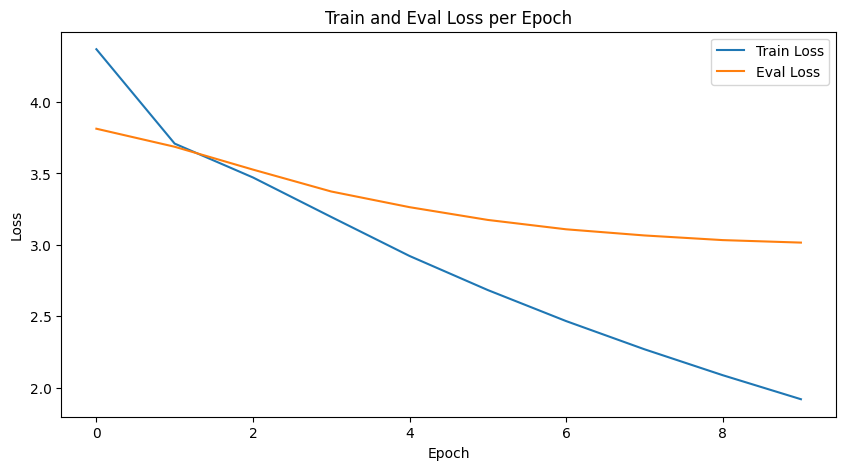

In [15]:
model = BertSummarizer(bert_model_name=model_name)
model = model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train_model(model, train_dataloader, eval_dataloader, optimizer, criterion, num_epochs=10)

In [16]:
eval_data_sample = next(iter(eval_dataloader))
model.generate(eval_data_sample['input_ids'][:1].to('cuda'), eval_data_sample['attention_mask'][:1].to('cuda'), tokenizer)

'в субботу в матче « спартака » обы ##грал ##а « ливер ##пуль » и « ливер ##пуль » и « ливер ##пуль » и « ливер ##пуль » и « ливер ##пуль » и « ливер ##пуль » и « ливер ##пуль » — « ливер ##пуль » —'

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
def save_model(model, optimizer, path, epoch):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f'Model saved to {path}')

In [19]:
def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f'Model loaded from {path}, starting from epoch {start_epoch}')

    return model, optimizer, start_epoch

In [23]:
save_model(model, optimizer, epoch=10, path = '/content/drive/My Drive/bert_summarizer_checkpoint_1.pth')

Model saved to /content/drive/My Drive/bert_summarizer_checkpoint_1.pth


In [24]:
model, optimizer, start_epoch = load_model(model, optimizer, '/content/drive/My Drive/bert_summarizer_checkpoint_1.pth')


<ipython-input-19-ba5e643bcfa0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Model loaded from /content/drive/My Drive/bert_summarizer_checkpoint_1.pth, starting from epoch 10


## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [ ]:
def compute_metrics():
    #<YOUR CODE HERE>
    pass

def evaluation():
    #<YOUR CODE HERE>
    pass

## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("YOUR MODEL")
summary = #<YOUR CODE HERE>

## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*